# Evaluating experiments

In [85]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import warnings

import matplotlib as mpl

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import train
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)

In [40]:
def get_data(rundir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    rundata = []
    metrics = []
    sweep_metaconfigs = []
    base_metaconfigs = []
    for logdir in os.listdir(rundir):
        if os.path.isdir(os.path.join(rundir, logdir)):
            configfile, datafile, metricfile = [rundir + logdir + f for f in ["/config.json", "/data.json", "/metrics.json"]]
            with open(configfile, "r") as f:
                cfgs.append(json.load(f))
            try:
                with open(datafile, "r") as f:
                    rundata.append(json.load(f))
                with open(metricfile, "r") as f:
                    metrics.append(json.load(f))
            except FileNotFoundError:
                warnings.warn(f"No config / data files in {logdir}.")
        else:
            with open(rundir + logdir, "r") as f:
                base, sweep_config = json.load(f)
                sweep_metaconfigs.append(sweep_config)
                base_metaconfigs.append(base)
     
    # process data
    cfgs_flat = [utils.flatten_dict(c) for c in cfgs]
    for c in cfgs_flat:
        if len(c["optimizer_svgd_args"]) == 1:
            c["optimizer_svgd_args"] = onp.squeeze(c["optimizer_svgd_args"])
        if len(c["optimizer_ksd_args"]) == 1:
            c["optimizer_ksd_args"] = onp.squeeze(c["optimizer_ksd_args"])
    
    
    configs_df = pd.DataFrame(cfgs_flat)
    configs_df.rename(columns={"optimizer_svgd_args": "lr svgd", "optimizer_ksd_args": "lr ksd"}, inplace=True)
    
    metrics_df = pd.DataFrame(metrics)
    all_df = pd.concat([metrics_df, configs_df], axis=1)
    all_df["layers"] = all_df.layers.astype('str').astype('category')
    all_df["architecture"] = all_df.architecture.astype('str').astype('category')
    
    if all_df.isnull().values.any():
        warnings.warn("Detected NaNs in dataframe.")
    
    return all_df, rundata, cfgs, sweep_metaconfigs, base_metaconfigs

In [41]:
def plot_pdf(cfg: dict, log: dict):
    p = SVGD(**config.get_svgd_args(cfg)).target
    particles = np.array(log["particles"])[:, 0]
    lims = onp.squeeze([p.mean + d for d in (-1.5 * p.cov, 1.5 * p.cov)])
    
    grid = np.linspace(*lims, 100)
    plt.plot(grid, vmap(p.pdf)(grid))
    plt.hist(particles, density=True)

In [42]:
ls ../runs

ls: cannot access '../runs': No such file or directory


In [118]:
rundir = "../runs/four-dim/"
frame, rundata, configs, sweep_metaconfigs, base_metaconfigs = get_data(rundir)
relevant = ["ksd", "emd", "sinkhorn_divergence"] + ["lr ksd", "svgd_steps", "architecture", "layers"]
f = frame[relevant]
# f

<ipython-input-40-a143fe5bab76>:22: UserWarning: No config / data files in 2020-07-20__19:11:17.
  warnings.warn(f"No config / data files in {logdir}.")
<ipython-input-40-a143fe5bab76>:47: UserWarning: Detected NaNs in dataframe.
  warnings.warn("Detected NaNs in dataframe.")


In [122]:
t = onp.array([1,2])

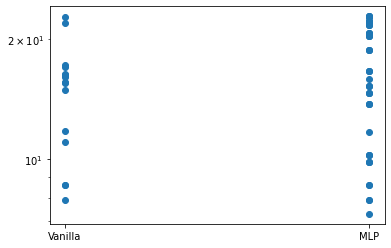

In [120]:
plt.plot(f.architecture, f.sinkhorn_divergence, "o")
plt.yscale("log")

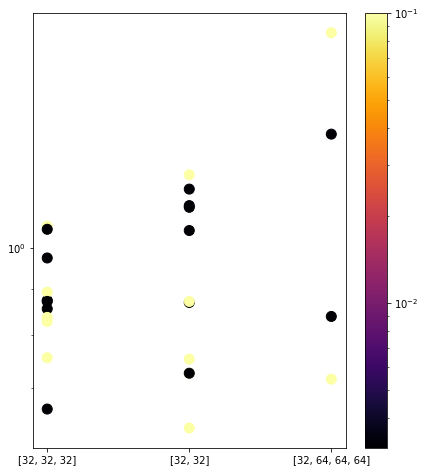

In [97]:
fig, ax = plt.subplots(figsize=[7, 8])
f_mlp = f[f.architecture == "MLP"]

f_mlp = f_mlp[f_mlp["emd"] < 2.0]
plt.scatter(f_mlp["layers"], f_mlp["emd"], c=f_mlp["lr ksd"], cmap="inferno", norm=mpl.colors.LogNorm(), s=100)
plt.yscale("log")
plt.colorbar()

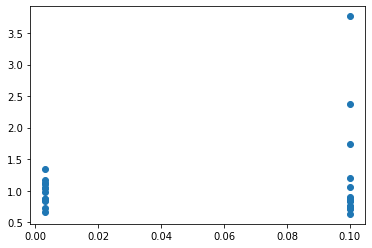

In [99]:
f_mlp = f[f.architecture == "MLP"]
plt.scatter(f_mlp["lr ksd"], f_mlp.emd)

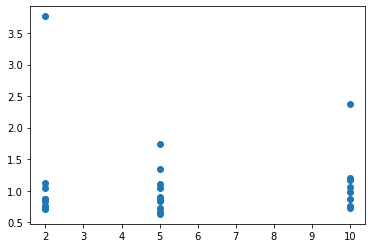

In [100]:
plt.scatter(f_mlp["svgd_steps"], f_mlp.emd)

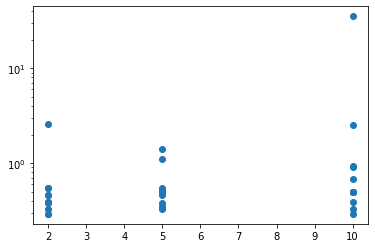

In [105]:
f_v = f[f.architecture == "Vanilla"]
plt.scatter(f_v["svgd_steps"], f_v["sinkhorn_divergence"])
plt.yscale("log")

# Past Evaluation

In [ ]:
sldkfjsl

In [73]:
f

,ksd,emd,sinkhorn_divergence,lr svgd,lr ksd,architecture,svgd_steps,ksd_steps,n_iter
0,0.014045,3.511141,12.309093,1.0,0.046415888336127774,MLP,10,1,3
1,0.039517,5.409584,29.264531,1.0,0.1,MLP,5,1,6
2,0.015088,6.959671,48.429041,10.0,0.01,MLP,1,1,30
3,0.016252,2.939976,8.633116,1.0,0.001,MLP,5,1,6
4,0.013374,2.929179,8.574354,1.0,0.01,Vanilla,10,1,3
...,...,...,...,...,...,...,...,...,...
167,0.018863,2.221124,4.921567,1.0,0.0021544346900318843,MLP,5,1,6
168,0.009826,2.499694,6.242920,1.0,1.0,Vanilla,10,1,3
169,0.019868,2.575841,6.621160,1.0,0.001,MLP,2,1,15
170,0.020490,2.593768,6.714664,1.0,0.01,MLP,10,1,3


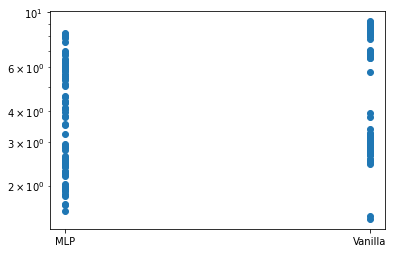

In [74]:
plt.plot(f["architecture"], f["emd"], "o")
plt.yscale("log")

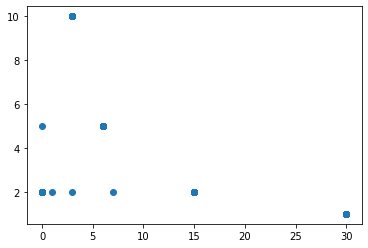

In [75]:
plt.plot(f["n_iter"], f["svgd_steps"], "o")

In [62]:
pd.Categorical(f.architecture)

[MLP, MLP, MLP, MLP, Vanilla, ..., MLP, Vanilla, MLP, MLP, MLP]
Length: 172
Categories (2, object): [MLP, Vanilla]

Best KSD learning rate is around 

The best KSD learning rate seems to be around $0.002$ to $0.004$. (for [32, 32] layers)

The best SVGD learning rate seems to be clearly 1. (again, for [32, 32] MLP).

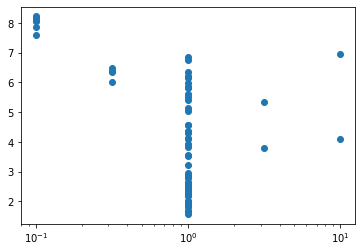

In [89]:
f_mlp = f[f["architecture"] == "MLP"]
plt.plot(f_mlp["lr svgd"], f_mlp["emd"], "o")
plt.xscale("log")

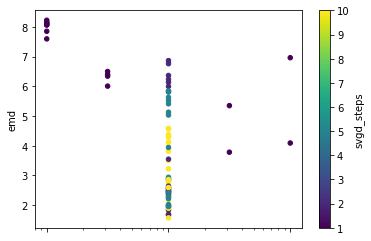

In [90]:
f_mlp.plot.scatter("lr svgd", "emd", c="svgd_steps", cmap="viridis")
plt.xscale("log")

## Look at individual runs

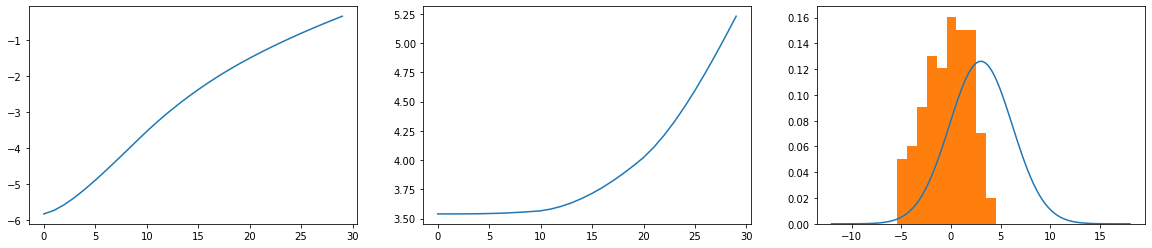

In [19]:
n = 0
fig, axs = plt.subplots(1, 3, figsize=[20,4])
axs[0].plot(data[n]["mean"])
axs[1].plot(data[n]["var"])
plot_pdf(configs[n], data[n])
